In [5]:
from collections import defaultdict

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from data import tfrecord_dataset, train_test_split
from models import SeluConv3D, SeluDense
from plot import plot_slice, plot_volume_animation
from config import (
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    LIDC_SMALL_UNLABELED_TFRECORD,
    LIDC_BIG_UNLABELED_TFRECORD,
    SMALL_PATCH_SHAPE,
    BIG_PATCH_SHAPE,
    SEED,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

In [6]:
small_pos_x = tfrecord_dataset(LIDC_SMALL_POS_TFRECORD)
pos_samples = sum(1 for _ in small_pos_x)
print(f"{pos_samples = }")

big_pos_x = tfrecord_dataset(LIDC_BIG_POS_TFRECORD)
pos_samples = sum(1 for _ in big_pos_x)
assert sum(1 for _ in big_pos_x) == pos_samples

small_neg_x = tfrecord_dataset(LIDC_SMALL_NEG_TFRECORD)
neg_samples = sum(1 for _ in small_neg_x)
print(f"{neg_samples = }")

big_neg_x = tfrecord_dataset(LIDC_BIG_NEG_TFRECORD)
neg_samples = sum(1 for _ in big_neg_x)
assert sum(1 for _ in big_neg_x) == neg_samples

labeled_samples = pos_samples + neg_samples
print(f"{labeled_samples = }")

small_unlabeled_x = tfrecord_dataset(LIDC_SMALL_UNLABELED_TFRECORD)
unlabeled_samples = sum(1 for _ in small_unlabeled_x)
print(f"{unlabeled_samples = }")
big_unlabeled_x = tfrecord_dataset(LIDC_BIG_UNLABELED_TFRECORD)
assert unlabeled_samples == sum(1 for _ in big_unlabeled_x)

pos_samples = 379
neg_samples = 375
labeled_samples = 754
unlabeled_samples = 385


In [7]:
subset_size = 200
assert subset_size % 2 == 0

In [8]:
pos_x = tf.data.Dataset.zip((small_pos_x, big_pos_x))
classification_pos_dataset = tf.data.Dataset.zip(
    (
        pos_x.take(subset_size // 2),
        tf.data.Dataset.from_tensor_slices(np.int8([[1]])).repeat(subset_size // 2),
    )
)
assert sum(1 for _ in classification_pos_dataset) == subset_size // 2

neg_x = tf.data.Dataset.zip((small_neg_x, big_neg_x))
classification_neg_dataset = tf.data.Dataset.zip(
    (
        neg_x.take(subset_size // 2),
        tf.data.Dataset.from_tensor_slices(np.int8([[0]])).repeat(subset_size // 2),
    )
)
assert sum(1 for _ in classification_neg_dataset) == subset_size // 2

classification_dataset = classification_pos_dataset.concatenate(
    classification_neg_dataset
).shuffle(buffer_size=subset_size, reshuffle_each_iteration=False)
assert sum(1 for _ in classification_dataset) == subset_size

In [9]:
unsupervised_dataset = (
    small_pos_x.skip(subset_size // 2)
    .concatenate(small_neg_x.skip(subset_size // 2))
    .concatenate(small_unlabeled_x)
)
unsupervised_samples = sum(1 for _ in unsupervised_dataset)
print(f"{unsupervised_samples = }")
assert unsupervised_samples == (labeled_samples - subset_size + unlabeled_samples)
unsupervised_dataset = tf.data.Dataset.zip((unsupervised_dataset, unsupervised_dataset))
unsupervised_dataset

unsupervised_samples = 939


<ZipDataset shapes: ((None, None, None, None), (None, None, None, None)), types: (tf.float32, tf.float32)>

In [ ]:
# check that the two datasets are non-overlapping

# for (_, big), _ in classification_dataset:
#    for x, _ in unsupervised_dataset:
#        assert not tf.reduce_all(tf.equal(big, x))

In [ ]:
val_perc = 0.1
batch_size = 16
noise_stddev = 0.05

In [ ]:
@tf.function
def add_random_gaussian_noise(x, y):
    small, big = x
    noise = tf.random.normal(
        shape=SMALL_PATCH_SHAPE, mean=0, stddev=noise_stddev, dtype=tf.float32
    )
    small = small + noise
    small = tf.clip_by_value(small, 0, 1)
    small.set_shape(SMALL_PATCH_SHAPE)  # help shape inference
    noise = tf.random.normal(
        shape=BIG_PATCH_SHAPE, mean=0, stddev=noise_stddev, dtype=tf.float32
    )
    big = big + noise
    big = tf.clip_by_value(big, 0, 1)
    big.set_shape(BIG_PATCH_SHAPE)  # help shape inference
    return (small, big), y

In [ ]:
unsupervised_train_dataset, unsupervised_val_dataset = train_test_split(
    unsupervised_dataset,
    test_perc=val_perc,
    cardinality=unsupervised_samples,
)
unsupervised_val_dataset = (
    unsupervised_val_dataset.cache()
    # .map(add_random_gaussian_noise, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
unsupervised_train_dataset = (
    unsupervised_train_dataset.cache()  # must be called before shuffle
    # .map(add_random_gaussian_noise, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
unsupervised_train_dataset

In [ ]:
encoder = keras.Sequential(
    [
        keras.layers.InputLayer(SMALL_PATCH_SHAPE, name="encoder_input"),
        SeluConv3D(
            filters=32,
            kernel_size=3,
            name="encoder_selu_conv3d_1",
        ),
        keras.layers.MaxPooling3D((1, 2, 2), name="encoder_maxpool_1"),
        SeluConv3D(
            filters=64,
            kernel_size=3,
            name="encoder_selu_conv3d_2",
        ),
        keras.layers.MaxPooling3D((1, 2, 2), name="encoder_maxpool_2"),
        SeluConv3D(
            filters=128,
            kernel_size=3,
            name="encoder_selu_conv3d_3",
        ),
        keras.layers.MaxPooling3D((1, 2, 2), name="encoder_maxpool_3"),
        SeluConv3D(
            filters=256,
            kernel_size=3,
            name="encoder_selu_conv3d_4",
        ),
        keras.layers.MaxPooling3D((1, 2, 2), name="encoder_maxpool_4"),
    ],
    name="encoder",
)
encoder.summary()

In [ ]:
decoder = keras.Sequential(
    [
        keras.layers.InputLayer(encoder.output_shape[1:], name="decoder_input"),
        keras.layers.UpSampling3D((1, 2, 2), name="decoder_upsampling_0"),
        SeluConv3D(
            filters=256,
            kernel_size=3,
            name="decoder_selu_conv3d_1",
        ),
        keras.layers.UpSampling3D((1, 2, 2), name="decoder_upsampling_1"),
        SeluConv3D(
            filters=128,
            kernel_size=3,
            name="decoder_selu_conv3d_2",
        ),
        keras.layers.UpSampling3D((1, 2, 2), name="decoder_upsampling_2"),
        SeluConv3D(
            filters=64,
            kernel_size=3,
            name="decoder_selu_conv3d_3",
        ),
        keras.layers.UpSampling3D((1, 2, 2), name="decoder_upsampling_3"),
        SeluConv3D(
            filters=32,
            kernel_size=3,
            name="decoder_selu_conv3d_4",
        ),
        keras.layers.Dense(1, activation="sigmoid", name="decoder_final_dense"),
    ],
    name="decoder",
)
decoder.summary()

In [ ]:
autoencoder = keras.Sequential(
    [
        keras.layers.InputLayer(SMALL_PATCH_SHAPE, name="autoencoder_input"),
        encoder,
        decoder,
    ],
    name="autoencoder",
)
autoencoder.summary()

In [ ]:
patience = 30
learning_rate = 1e-5

In [ ]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)

model_fname = f"models/autoencoder.h5"
log_dir = f"logs/autoencoder"
autoencoder = train_model_with_early_stopping(
    autoencoder,
    unsupervised_train_dataset,
    unsupervised_val_dataset,
    patience,
    "val_loss",
    model_fname,
    log_dir,
    verbose_checkpoint=1,
)

In [ ]:
autoencoder = keras.models.load_model("models/autoencoder.h5")

In [ ]:
original, _ = next(iter(unsupervised_val_dataset.unbatch().batch(1).skip(0)))
plot_volume_animation(original[0, :])

In [ ]:
out = autoencoder(original, training=False)
plot_volume_animation(out[0, :])

In [10]:
def build_3d_cnn():
    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="small_selu_conv3d_1",
    )(input_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_1")(x_small)
    x_small = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="small_selu_conv3d_2",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_2")(x_small)
    x_small = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="small_selu_conv3d_3",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_3")(x_small)
    x_small = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="small_selu_conv3d_4",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_4")(x_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPooling3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="big_selu_conv3d_1",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_1")(x_big)
    x_big = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="big_selu_conv3d_2",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_2")(x_big)
    x_big = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="big_selu_conv3d_3",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_3")(x_big)
    x_big = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="big_selu_conv3d_4",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_4")(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")
    x = SeluDense(128, name="selu_dense")(x)
    x = keras.layers.AlphaDropout(0.5)(x)
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [11]:
def build_ae_pretrained_3d_cnn():
    small_encoder = keras.models.load_model("models/autoencoder.h5").get_layer(
        "encoder"
    )
    small_encoder._name = "small_encoder"
    for layer in small_encoder.layers:
        layer._name = "small_" + layer._name
    small_encoder.trainable = False

    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = small_encoder(input_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    big_encoder = keras.models.load_model("models/autoencoder.h5").get_layer("encoder")
    big_encoder._name = "big_encoder"
    for layer in big_encoder.layers:
        layer._name = "big_" + layer._name
    big_encoder.trainable = False

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPooling3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = big_encoder(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")
    x = SeluDense(128, name="selu_dense")(x)
    x = keras.layers.AlphaDropout(0.5)(x)
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [13]:
tries = 1
fracs = (1, 5, 10)
test_perc = 0.25
batch_size = 8
learning_rate = 1e-5
num_epochs = 2
patience = 100
dataset = classification_dataset
metrics = [
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [15]:
data = defaultdict(list)
for _ in tqdm(range(tries)):
    full_train_dataset, test_dataset = train_test_split(
        dataset, test_perc=test_perc, seed=None
    )
    test_dataset = test_dataset.batch(batch_size)
    for frac in fracs:
        val_dataset, train_dataset = train_test_split(
            full_train_dataset, test_perc=(1 / frac), seed=None
        )
        val_dataset = val_dataset.batch(batch_size)
        if sum(1 for _ in val_dataset) == 0:
            val_dataset = test_dataset
        train_dataset = (
            train_dataset.cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    verbose=0,
                ),
                keras.callbacks.ModelCheckpoint(
                    "models/3d-cnn-wo-pretraining",
                    monitor="val_loss",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=0,
                ),
                # keras.callbacks.TensorBoard(
                #    log_dir=f"logs/3d-cnn-wo-pretraining-{frac}",
                #    histogram_freq=2,
                #    write_graph=False,
                #    profile_batch=0,
                # ),
            ],
        )
        cnn.load_weights("models/3d-cnn-wo-pretraining")
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("3D CNN W/O pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("3D CNN W/O pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

        cnn = build_ae_pretrained_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    verbose=0,
                ),
                keras.callbacks.ModelCheckpoint(
                    "models/3d-cnn-w-pretraining",
                    monitor="val_loss",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=0,
                ),
                # keras.callbacks.TensorBoard(
                #    log_dir=f"logs/3d-cnn-w-pretraining-{frac}",
                #    histogram_freq=2,
                #    write_graph=False,
                #    profile_batch=0,
                # ),
            ],
        )
        cnn.load_weights("models/3d-cnn-w-pretraining")
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("3D CNN W/ pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("3D CNN W/ pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

df = pd.DataFrame(data)
df.to_csv("frac-training.csv", index=False)

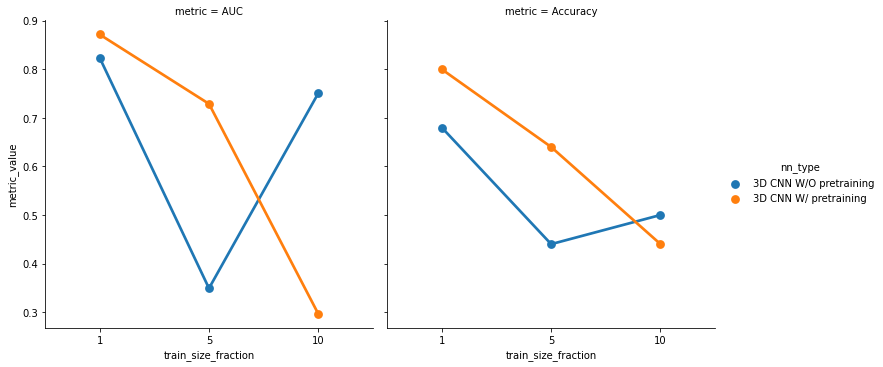

In [16]:
df = pd.read_csv("frac-training.csv")
sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    hue="nn_type",
    col="metric",
    kind="point",
    data=df,
)